# <center>**Ising Hamiltonian in Nambu Formalism** </center>
----
----
<br>

## 1. Ising Hamiltonian
----
Thanks to the Jordan-Wigner transformation we can tranform the spin operators of the Ising Hamiltonian \begin{equation}
H = -\sum_{j=1}^L \left(J_j^x\sigma_j^x\sigma_{j+1}^x + J_j^y\sigma_j^y\sigma_{j+1}^y\right) - \sum_{j=1}^L h_j \sigma_j^z,
\end{equation}
into spinless fermions obtaining, for the case of *open boundary conditions*, the following Hamiltonian \begin{equation}
H_\mathrm{OBC} = -\sum_{j=1}^{L-1}\left(J_j^+ c^\dagger_jc_{j+1}+ J_j^-c^\dagger_jc^\dagger_{j+1} + \text{h.c.} \right) + \sum_{j=1}^L h_j \left( 2 n_j - 1\right),
\end{equation}
where\begin{equation}
J^\pm \equiv J_j^x \pm J_j^y.
\end{equation}

In case of periodic boundary conditions one has\begin{equation}\boxed{
H_\mathrm{PBC} = \underbrace{-\sum_{j=1}^{L-1}\left(J_j^+ c^\dagger_jc_{j+1}+ J_j^-c^\dagger_jc^\dagger_{j+1} + \text{h.c.} \right) + \sum_{j=1}^L h_j \left( 2 n_j - 1\right)}_{H_\mathrm{OBC}} + (-1)^p \left(J_L^+ c_L^\dagger c_1 + J_L^- c^\dagger_Lc_1^\dagger + \text{h.c.} \right)}
\end{equation}
where $p=0$ applies to the even-fermion sector, $p=1$ to the odd-fermion sector.

**WARNING.** You can take $L$ to be even, no problem. But $p$ is associated to the parity in the *number of fermions*: you can have an **odd** number of fermions even if $L$ is even. In principle you need to consider *both values of* $p$.
<br>

## 2. Nambu formalism
----
We can consider the general quadratic fermionic form\begin{equation}
H = \Psi^\dagger \mathbb{H} \Psi \equiv \begin{pmatrix}\mathbf{c}^\dagger &&\mathbf{c}\end{pmatrix} \begin{pmatrix} \mathbf{A} && \mathbf{B} \\ -\mathbf{B}^* && -\mathbf{A}^* \end{pmatrix} \begin{pmatrix} \mathbf{c} \\ \ \mathbf{c}^\dagger \end{pmatrix}.
\end{equation}

The blocks are such that $\mathbf{A}^\dagger = \mathbf{A}$ and $\mathbf{B} = -\mathbf{B}^T$ and have the following form\begin{align}
&A_{j,j} = h_j,\\
&A_{j,j+1} = A_{j+1,j} = -\frac{J_j^+}{2} \equiv - \frac{J_j}{2}, \\
&B_{j,j} = 0,\\
&B_{j,j+1} = -B_{j+1,j} = -\frac{J_j^-}{2} \equiv -\kappa \frac{J_j}{2},
\end{align}
where we have assumed $ J_j^+ = J_j $ and $ J_j^-=\kappa J$. In case of periodic boundary conditions we have to consider also the following matrix elements\begin{align}
&A_{L,1} = A_{1,L} = (-1)^p \frac{J_L}{2} \\
&B_{L,1} = -B_{1,L} = (-1)^p \frac{\kappa J_L}{2}
\end{align}



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse as sps
import scipy.optimize as optimization
import seaborn as sns

from numba import njit

%matplotlib inline
#%matplotlib widget

Comments on python:

isinstance (object, classinfo)

Returns a Boolean stating whether the object is an instance or subclass of another object.

class scipy.sparse.dok_matrix(arg1, shape=None, dtype=None, copy=False)

is a dictionary of keys based sparse matrix. This is an efficient structure for constructing sparse matrices incrementally.
See https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html

In particular:
dok_matrix.setdiag(values, k=0)
sets the off-diagonal values (i,i+k) (default is k=0, the main diagonal).

The construction of $\mathbb{H}$ uses *sps.kron* by multiplying the matrices A and B by the block matrices TL=Top-left, TR, BL, BR.

pbc = False and $p=0$ are default values in buildH.

In [134]:

#Defines the Hamiltonian, the parameters are the transverse magnetic field h0,
#A boolean PBC(Periodic Boundary conditions) and the size of the system L

def Hamiltonian(h0,PBC,L,J=1.0):
  TL = sps.csr_matrix(np.array([[1,0],[0,0]]))
  TR = sps.csr_matrix(np.array([[0,1],[0,0]]))
  BL = sps.csr_matrix(np.array([[0,0],[1,0]]))
  BR = sps.csr_matrix(np.array([[0,0],[0,1]]))
    
  kappa = 1.
  h=h0

  A = sps.dok_matrix((L,L),dtype=np.float32)
  A.setdiag(h)
  A.setdiag(-J/2, k = 1)
  A.setdiag(-J/2, k = -1)

  B = sps.dok_matrix((L,L),dtype=np.float32)
  B.setdiag(-kappa*J/2, k = 1)
  B.setdiag(kappa*J/2, k = -1)

  if PBC:
    # print("PBC")
    H=[0 for i in range(2)]
    for p in range(2):
        A.setdiag(((-1)**p)*J/2, k=L-1)
        A.setdiag(((-1)**p)*J/2, k=1-L)
        B.setdiag(-((-1)**p)*kappa*J/2, k=L-1)
        B.setdiag(((-1)**p)*kappa*J/2, k=1-L)
        H[p] = sps.kron(TL, A) + sps.kron(TR, B) + sps.kron(BL, -B) + sps.kron(BR, -A)
    Hmat = sps.kron(TL,H[0]) + sps.kron(BR,H[1])  
  else:
    Hmat = sps.kron(TL, A) + sps.kron(TR, B) + sps.kron(BL, -B) + sps.kron(BR, -A)
    Hmat = sps.kron(sps.eye(2),Hmat)
  # print(Hmat.toarray())
  return Hmat

#Return the two Hamiltonians for the different parities:

def Hparities(Htot):
    H = Htot
    Ld = int(H.shape[0]/2)
    return [H[0:Ld].T[0:Ld].T, H[Ld:].T[Ld:].T]
    
    

In [201]:
## Next we have the functions to diagonalize the Hamiltonian:
#@njit()
def diagonalization(Hmat,eigvalues):
    if eigvalues:
        aut = np.linalg.eigh(Hmat)
    else:
        aut = np.linalg.eigvalsh(Hmat)
    return aut

def zero_subspace(eigsystem,eps=10**(-4)):
    
    size=len(eigsystem[1][0])
    zeroindex = [i for i, val in enumerate(eigsystem[0]) if np.abs(val) < eps]
    zeroeigenv=[eigsystem[1][i] for i in zeroindex]
    
    if(len(zeroeigenv))!=2:
        #print("Alert!, there is no double degeneracy:"+str(len(zeroeigenv)))
        return
    a,b=np.zeros(size),np.zeros(size)
    
    for i in range(2):
        a+=zeroeigenv[i]+np.concatenate((zeroeigenv[i][int(size/2):],zeroeigenv[i][:int(size/2)]))
        b+=(-1)**(i)*np.concatenate((zeroeigenv[i][int(size/2):],zeroeigenv[i][:int(size/2)]))+(-1)**(i+1)*zeroeigenv[i]
    
    a=a/np.linalg.norm(a)
    b=b/np.linalg.norm(b)
    #print("Zero indexes",zeroindex,"a,b",a,b)
    
    eigenvalues=eigsystem[1]
    eigenvalues[zeroindex[0]]=(a+b)/np.sqrt(2)
    eigenvalues[zeroindex[1]]=(a-b)/np.sqrt(2)
    return eigenvalues


Text(0, 0.5, '$E$')

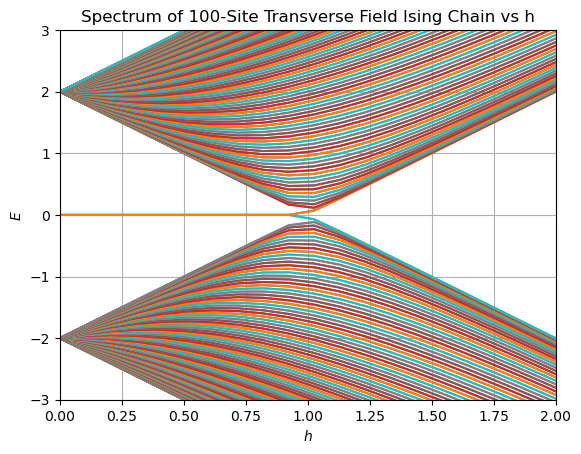

In [136]:

L=100
Hs = np.r_[0:4:40j]
ens = np.zeros((len(Hs), 4*L), dtype=float)
eigv = np.zeros((len(Hs), 4*L , 1), dtype=float)


for (i,h) in enumerate(Hs):
  Hmat = Hamiltonian(h,False,L)
  val = diagonalization(Hmat.toarray(),False)
  ens[i] = np.sort(val)*2
  # print(val.imag)
  
  # print("matrix",a.conj().T@Hmat.toarray()@a)
  # print("vals",ens[i])

# We plot the spectrum.
# Zoom as you wish, if your %matplotlib notebook magic is properly working (not in Colab, apparently)
plt.figure()
plt.plot(Hs, ens, '-')
plt.title(r'Spectrum of '+str(L)+r'-Site Transverse Field Ising Chain vs h')
plt.grid()
plt.xlim((0,2))
plt.ylim((-3,3))
plt.xlabel(r'$h$')
plt.ylabel(r'$E$')

# Hmat.toarray()

### Assignement: Plot of spectrum for a uniform Ising chain in different regimes of transverse field ###
You should get something like:
![Spectrum_1.png](attachment:Spectrum_1.png)

![Spectrum_2.png](attachment:Spectrum_2.png)

<h2>3. Bogoliubov-de Gennes equations</h2>

----

<br>

The Bogoliubov-de Gennes equations arise from the spectral problem\begin{equation}
\mathbb{H}\begin{pmatrix}\mathbf{u}_\mu\\ \mathbf{v}_\mu\end{pmatrix}= \varepsilon_\mu \begin{pmatrix}\mathbf{u}_\mu\\ \mathbf{v}_\mu\end{pmatrix},
\end{equation}
which reads\begin{equation}\begin{cases}
\mathbf{A}\mathbf{u}_\mu + \mathbf{B}\mathbf{v}_\mu =\varepsilon_\mu \\
-\mathbf{B}^*\mathbf{u}_\mu - \mathbf{A}^*\mathbf{v}_\mu =\varepsilon_\mu \\
\end{cases}
\end{equation}

It follows from this that if $\left(\mathbf{u}_\mu,\ \mathbf{v}_\mu\right)$ is an eigenvector with eigenvalue $\varepsilon_\mu$ then also $-\varepsilon_\mu$ is an eigenvalue of the problem with eigenvector $\left(\mathbf{v}^*_\mu,\ \mathbf{u}_\mu^*\right)$.
We can organise the eigenvectors in a unitary (orthogonal, if the solutions are real) $2L\times 2L$ matrix
$$
\mathbb{U} = \begin{pmatrix}
\mathbf{u_1} &\cdots &\mathbf{u_1} &\mathbf{v_1}^* &\cdots &\mathbf{v_L}^*\\
\mathbf{v_1} &\cdots &\mathbf{v_L} &\mathbf{u_1}^* &\cdots &\mathbf{u_1}^*
\end{pmatrix} = \begin{pmatrix}
\mathbf{U} &\mathbf{V^*}\\
\mathbf{V} &\mathbf{U^*}
\end{pmatrix}
$$


The next thing to do would be to produce a function that, given $\mathbb{H}$, returns the eigenvalues and the eigenvectors (the $\mathbb{U}$ matrix) in some useful form. This is crucial to calculate the Green's functions, which is one of our next goals.

Obviously, you need to address the zero-energy eigenvalues properly, for that.

<h2>3.1 Zero energy eigenvectors</h2>

----
We have to be carefull with zero energy eigenvectors. Indeed, the zero-energy
eigenvalues, if present, must come in an even number simply because if $\epsilon_\mu = 0$ then also $-\epsilon_\mu = 0$. It follows that the eigenspace of zero eigenvalue is degenerate and unfortunately the diagonalization routine does not give us the correct form needed to preserve fermionic commutation relations, i.e, the one used in the matrix $\mathbb{U}$. To enforce such a structure you can exploit the swap matrix

$$
\mathbb{S} = \begin{pmatrix}
0_{L\times L} &I_{L\times L}\\
I_{L\times L} &0_{L\times L}
\end{pmatrix} = \sigma^x\otimes I_{L\times L}.
$$

Since $\mathbb{S}\mathbb{H}=-\mathbb{H}\mathbb{S}$, then if $(\mathbf{u}_\mu,\mathbf{v}_\mu)^T$ is a zero energy eigenvector, so is $\mathbb{S}(\mathbf{u}_\mu,\mathbf{v}_\mu)^T =(\mathbf{v}_\mu,\mathbf{u}_\mu)^T$. Hence
the zero-energy subspace is invariant for $\mathbb{S}$. The eigenvalues of $\mathbb{S}$ are only $\pm 1$, then, starting from the zero-energy eigenvectors given by the diagonalization routine namely $\mathbf{w}$ and $\mathbf{w}'$, we can define

\begin{align}
&\mathbf{a}' = \mathbb{S}(\mathbf{w}+\mathbf{w}')+(\mathbf{w}+\mathbf{w}'),\quad \mathbf{a}= \frac{\mathbf{a}'}{||\mathbf{a}'||}\\
&\mathbf{b}'= \mathbb{S}(\mathbf{w}-\mathbf{w}')-(\mathbf{w}-\mathbf{w}'),\quad \mathbf{b}= \frac{\mathbf{b'}}{||\mathbf{b'}||},
\end{align}

where $\mathbf{a}$ and $\mathbf{b}$ are normalized zero enery eigenvectors even and odd under  $\mathbb{S}$ respectively, which means that they will be of the form

\begin{align}
\mathbf{a} = \begin{pmatrix}
\mathbf{u}\\
\mathbf{u}
\end{pmatrix},\quad\mathbf{b}=\begin{pmatrix}
\mathbf{v}\\
-\mathbf{v}
\end{pmatrix}.
\end{align}

Finally the combinations

\begin{align}
\frac{1}{\sqrt{2}}\begin{pmatrix}
\mathbf{u}+\mathbf{v}\\
\mathbf{u}-\mathbf{v}
\end{pmatrix}\quad\text{and}\quad\frac{1}{\sqrt{2}}\begin{pmatrix}
\mathbf{u}-\mathbf{v}\\
\mathbf{u}+\mathbf{v}
\end{pmatrix},
\end{align}

are exactly the zero energy eigenvectors with the correct structure we were looking for.

### Assignement: Write a function Diagoanalize(H) which does that for us ###


In [166]:
h=0.5
L=4
Hmat = Hamiltonian(h,False,L)
H1,H2=Hparities(Hmat.toarray())
val= diagonalization(H1,True)
print(val[0])


[-1.4134192  -1.16612325 -0.80009785 -0.04739379  0.04739379  0.80009785
  1.16612325  1.4134192 ]


<h2> Problem 3: Anderson localisation of states for the disordered Ising chain</h2>
<HR>
We consider the model with disorder in both $J_j$ and $h_j$, we assume that $J_{j}\in[J_\mathrm{min}; 1]$ and $h_j\in [0; h_\mathrm{max}]$ are uniformly distributed, with $J_\mathrm{min} > 0$. The spinor eigenfunctions
\begin{equation}
    \mathbf{W}_{j\mu}=\begin{pmatrix}
    \mathbf{U}_{j\mu}\\
    \mathbf{V}_{j\mu}
    \end{pmatrix},
\end{equation}
    
are localised in space. This means that, fixing $h_\mathrm{max}$ and $J_\mathrm{min}$, there exists a localisation length $\xi_{\mathrm{loc}}$ such that
    \begin{equation}
    |\mathbf{W}_{j\mu}| = \sqrt{|\mathbf{U}_{j\mu}|^2+|\mathbf{V}_{j\mu}|^2}\leq Ce^{-|j-l_\mu|/\xi_{\mathrm{loc}}}\qquad\forall\mu,
    \end{equation}
    where where $l_\mu$ depends on $\mu$ and $C$ is a constant.
    
### They should look like: ###
    
![W_disordered.png](attachment:W_disordered.png)

Localisation can be studied also using the inverse
participation ratio
$$
\mathrm{IPR}_\mu = \sum_{j}||\mathbf{W}_{j\mu}|^2|^2 = \sum_{j}||\mathbf{U}_{j\mu}|^2+|\mathbf{V}_{j\mu}|^2|^2.
$$
Averaging $\mathrm{IPR}_\mu$ over $\mu$ (and over the disorder) we can verify that it tends towards a constant value, for increasing $L$.

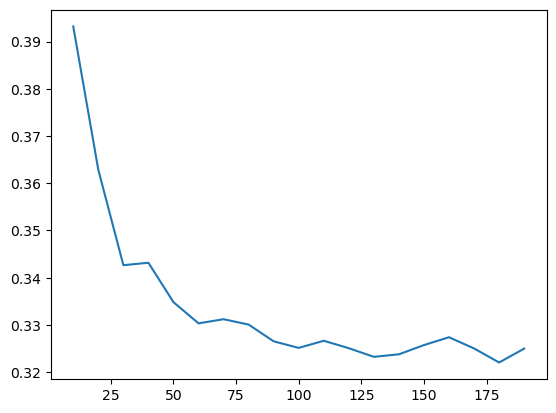

In [205]:
#A function for the random sequences is created:
def RandCoeffs(samples,Jmin,Hmax,seed1=0,seed2=34159):
    Jrng= np.random.default_rng(seed1)
    Hrng= np.random.default_rng(seed2)
    return Jrng.uniform(Jmin,1.0,samples),Hrng.uniform(0,Hmax,samples)

# Returns a matrix with all the spinors in a cycle:
def spinors(J,H,PBC,L,p):
    Hmat = Hamiltonian(H,PBC,L,J)
    Ham=Hparities(Hmat.toarray())
    vali= diagonalization(Ham[p],True)
    A=zero_subspace(vali)
    if A is None:
        val=vali
    else:
        val=[vali[0],zero_subspace(vali)]
    W=np.array([[ eigvect[i]**2+eigvect[i+L]**2 for i in range(L) ] for eigvect in val[1][:L]])
    return W
    
def IPRmu(W,L):
    return np.array([ np.linalg.norm(W[i,:])**2 for i in range(L)])

def Average_IPRmu(L,Jmin,Hmax,PBC,N,p,seed1,seed2):
    J,H=RandCoeffs(L*N,Jmin,Hmax,seed1,seed2)
    W=np.zeros((L,L))
    for i in range(N):
        B=spinors(J[i*L:(i+1)*L],H[i*L:(i+1)*L],PBC,L,p)
        W+=IPRmu(B,L)
    W/=N
    return np.array(W)

def Average_IPR(L,Jmin,Hmax,PBC,N,p):
    return np.array([np.mean(Average_IPRmu(i,Jmin,Hmax,PBC,N,p,i,i+1)) for i in L])

Jmin=0.0
Hmax=1.0
PBC=False
N=100
p=0
L=[10*i for i in range(1,20)]
Y=Average_IPR(L,Jmin,Hmax,PBC,N,p)
plt.figure()
plt.plot(L,Y)

<h2>4. Green's functions at T=0</h2>

----
We would like to compute now the normal and anomalous Green's functions at zero temperature:
$$
\mathbf{G}_{jj'} = \langle \emptyset_p | \hat{c}_{j} \hat{c}_{j'}^\dagger | \emptyset_p \rangle     \\
\mathbf{F}_{jj'} = \langle \emptyset_p | \hat{c}_{j} \hat{c}_{j'} | \emptyset_p \rangle     \\
$$

Where $|\emptyset_p\rangle$ is the Bogoliubov's vacuum, meaning  $\hat{\gamma}_\mu | \emptyset_p \rangle =0$  while  $\hat{c}_j | \emptyset_p \rangle \neq 0$. The relation between $\gamma$ and $\hat{c}$ is the following:
$$
\hat{c}_j = \sum_\mu ( U_{j \mu} \hat{\gamma}_\mu + V_{j \mu}^* \hat{\gamma}_\mu^\dagger )\\
\hat{c}_j^\dagger = \sum_\nu ( V_{j \nu} \hat{\gamma}_\nu + U_{j \nu}^* \hat{\gamma}_\nu^\dagger )
$$
Therefore the Green's functions are
$$
\mathbf{G}_{jj'} = \langle \emptyset_p | \Big(\sum_\mu U_{j\mu} \hat{\gamma}_\mu \Big) \Big(\sum_\nu U_{j' \nu}^* \hat{\gamma}^\dagger_\nu \Big) | \emptyset_p \rangle= (\mathbf{U}^{\phantom\dagger} \!\! \mathbf{U}^\dagger)_{jj'} \\
\mathbf{F}_{jj'} = \langle \emptyset_p | \Big(\sum_\mu U_{j\mu} \hat{\gamma}_\mu \Big) \Big(\sum_\nu V_{j' \nu}^* \hat{\gamma}^\dagger_\nu \Big) | \emptyset_p \rangle= (\mathbf{U}^{\phantom\dagger} \!\! \mathbf{V}^\dagger)_{jj'} \\
$$
With those, we can, among other things, compute spin-spin correlation functions:
$$
C^{xx}_{j_1 , j_2} = \langle \hat{\sigma}_{j_1}^x  \hat{\sigma}_{j_2}^x \rangle = \langle (\hat{c}_{j_1}^\dagger +\hat{c}_{j_1}) \exp \Big( i \pi \sum_{j=j_1}^{j_2-1}\hat{n}_j \Big) (\hat{c}_{j_2}^\dagger +\hat{c}_{j_2} ) \rangle
$$
Recalling the Majorana fermions $\hat{\mathrm{A}}_j=(\hat{c}_{j}^\dagger +\hat{c}_{j} )$ and $\hat{\mathrm{B}}_j=(\hat{c}_{j}^\dagger -\hat{c}_{j} )$ we can rewrite this as
$$
C^{xx}_{j_1 , j_2} = \langle \hat{\mathrm{B}}_{j_1} \Big( \prod_{j=j_1+1}^{j_2-1} \hat{\mathrm{A}}_j \hat{\mathrm{B}}_j \Big) \hat{\mathrm{A}}_{j_2} \rangle
$$
Using Wick's theorem, the only non-zero contributions come from contractions of $\hat{\mathrm{A}}$ operators with $\hat{\mathrm{B}}$ operators. By performing the calculations, considering real $\mathbf{G}$ and $\mathbf{F}$:
$$
\langle \hat{\mathrm{B}}_j \hat{\mathrm{A}}_{j'} \rangle = \delta_{j,j'}-2(\mathbf{G}_{jj'}+\mathbf{F}_{jj'}) \overset{def}{=} \mathbf{M}_{jj'} \\
\langle \hat{\mathrm{A}}_j \hat{\mathrm{B}}_{j'} \rangle = -\langle \hat{\mathrm{B}}_{j'} \hat{\mathrm{A}}_j\rangle =- \mathbf{M}_{j'j}
$$
where the last comes from anticommutation rules of Majorana fermions.
The Wick sum can therefore be expressed as the determinant of the sector of the $\mathbf{M}$ matrix spacing the rows $[j_1 ; j_2-1]$ and the columns $[j_1+1 ; j_2]$

### Assignement: Write a function compute_green(U,V) which calculated G and F given U and V. Next calculate the appropriate determinant of the sector of $\mathbf{M}$ to get the spin-spin correlations ###

<h1> Problem 6: Spin-spin correlation function</h1>
<HR>
<h3> <b>Part 1</b> </h3>

We consider a uniform Ising chain with PBC and we work in the fermionic ABC sector. We show the behaviour of the spin-spin correlation function\begin{equation}
C_{0j}^{xx} \equiv \left\langle\sigma_0^x \sigma_j^x \right\rangle
\end{equation}
against j for different values of $h/J$. Correlations tend to decrease until $j \approx L/2$ which is the farthest site from the origin since we are considering a chain with periodic boundary conditions.

<h3> <b>Part 2</b> </h3>

We study the behaviour of
\begin{equation}
C_{0L/2}^{xx} \equiv \left\langle\sigma_0^x \sigma_{L/2}^x \right\rangle
\end{equation}
against increasing values of the chain size $L$ and find the following scalings

> a) Attains a finite non-zero value for $h/J=1/2 < 1$
>
> b) Criticality: power-law-decaying behaviour for $h/J=1$
>
> c) Exponential decay to zero for $h/J=2 > 1$

![Cxx_h=1_2.png](attachment:Cxx_h=1_2.png)

![Cxx.png](attachment:Cxx.png)

![Cxx_h=2.png](attachment:Cxx_h=2.png)
    
![Cxx_h=1.png](attachment:Cxx_h=1.png)    

![Cxx_vs_j.png](attachment:Cxx_vs_j.png)

Finally we compare our results with the reference [P. Pfeuty. The one-dimensional ising model with a transverse
eld. Annals of Physics, 57(1):79-90, 1970](https://www.math.ucdavis.edu/~bxn/pfeuty1970.pdf)


<h1>4. Entanglement entropy</h1>
<HR>

We would like to compute the entanglement entropy defined as

\begin{equation}
S_l = -\mathrm{Tr}_{l}[\rho_{l}\log\rho_{l}],
\end{equation}

where $\rho_{l}$ is the reduced density matrix of a subsystem of size $l$, obtained from the density matrix $\rho_L=|\psi\rangle\langle\psi|$ of the full system through a partial trace over sites $\{l+1,\cdots,L\}$.

\begin{equation}
\rho_{l} = \mathrm{Tr}_{l+1,\cdots,L}[\rho_{L}].
\end{equation}

We consider the $2L\times 2L$ Majorana correlation matrix, which, in terms of the $\mathbf{G}$ and $\mathbf{F}$ matrices previously introduced and in the time independet case, is given by

\begin{equation}
\mathbb{M} = \mathbb{I}+i\begin{pmatrix}
\mathbf{0} &-\mathbf{I} +2\mathbf{G}-2\mathbf{F}\\
\mathbf{I} -2\mathbf{G}-2\mathbf{F} &\mathbf{0}
\end{pmatrix} \equiv \mathbb{I} + i\mathbb{A}.
\end{equation}

We notice that, since $\mathbf{G} = \mathbf{G}^T$ and $\mathbf{F} = \mathbf{F}^T$, then $\mathbb{A}$ is antisymmetric and $i\mathbb{A}$ is Hermitian. Now we consider the Majorana correlation matrix restircted to a sub-chain of lenght $l$

\begin{align}
\mathbb{M}_l = \mathbb{I}_l+i\mathbb{A}_l.
\end{align}

Finally we diagonalize $i\mathbb{A}_l$ and it can be shown that the entanglement entropy can be written in terms of its eigenvalues $\pm\lambda_q$, $q = 1,\dots, l$, as

\begin{equation}
S_l = -\sum_{q = 1}^{l}\left(\frac{1+\lambda_q}{2}\log\frac{1+\lambda_q}{2}+\frac{1-\lambda_q}{2}\log\frac{1-\lambda_q}{2}\right).
\end{equation}
    
### Assignement: Write a function ComputeLambda(G,F) which diagonalises the hermitean matrix $i\mathbb{A}_l$ ###

<h3><b>Problem 7. Ground state entanglement for a uniform Ising chain</b></h3>
We have computed the ground-state entanglement entropy for a uniform Ising chain, with l = L/2, and open boundary conditions. Increasing $L$ we have found that

a) S(L/2) tends to a constant for $h/J = 1/2$

b) S(L/2) tends to a constant for $h/J = 2$

c) S(L/2) grows logarithmically in the critical case $h/J = 1$

![S_vs_l.png](attachment:S_vs_l.png)



<h3><b> Comparison with CFT results</b></h3>

At the critical point $h = J = 1$ we compare our results we the exact results obtained through conformal field theory (CFT). In particular the CFT result for the entanglement entropy of sub-system of length $l$ with two
boundary points within a finite system of length $L$ is

\begin{equation}
S(l,L) = \frac{c}{3}\log\left(\frac{L}{\pi}\sin\frac{\pi l}{L}\right)+k,
\end{equation}

where c is the central of the CFT. In particular, we considered the critical Ising case ($\kappa$ = 1, h=J=1) and the XX-chain case ($\kappa$ = 0, J=1, h=0), which are described by a CFT with central charge $c=1/2$ and $c = 1$, respectively.  


![S_Ising_XX.png](attachment:S_Ising_XX.png)

In [149]:
L=4
J=np.array([i for i in range(L)])
A = sps.dok_matrix((L,L),dtype=np.float32)
A.setdiag(-J, k = 1)
A.setdiag(-J, k = -1)
A.toarray()

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0., -1.,  0., -2.],
       [ 0.,  0., -2.,  0.]], dtype=float32)